基于序列可能性定义重要性比率，实际上是几何平均。重要性项考虑了过去所有 token 重要性系数的几何，所以是 sequence level 的；而 GRPO 是算术平均，准确来说并不是论文里所说的 token level，因为每个 token 的优势估计都一样是从 batch 中计算得来的。

如下是当重要性比例全都小于 1，即当前 rollout 轨迹被弱化；如果对应优势 A < 0，则对应 Geometric Mean 会比 GRPO 的 Arithmetic Mean 更低，对应更容易被 clipped。

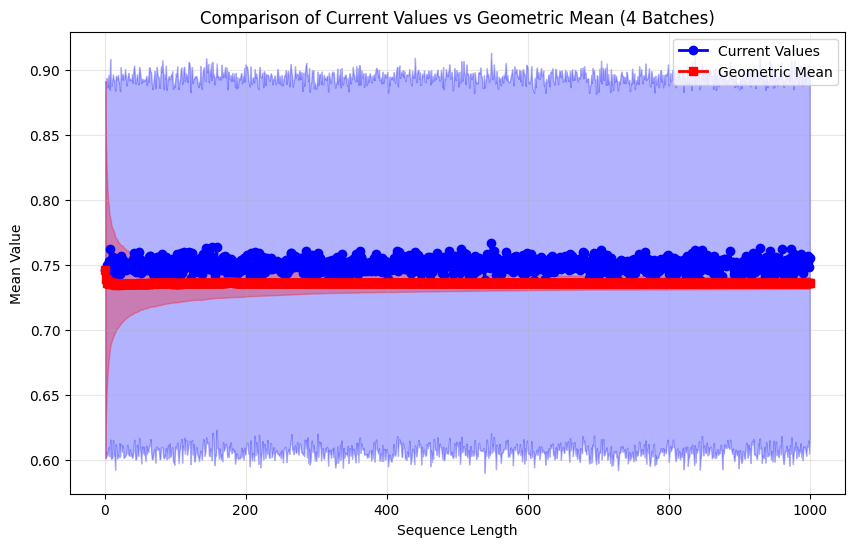

Current Values (final): 0.755 ±  0.139
Geometric Mean (final): 0.736 ±  0.005
0.018748071755078977


In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate 4 batches of sample data points
num_batches = 1000
sequence_length = 1000

# Generate data for each batch
all_current_values = []
all_geometric_means = []

for batch in range(num_batches):
    data_points = [np.random.uniform(0.5, 1.) for _ in range(sequence_length)]
    
    # Calculate current values and geometric mean for cumulative sequences
    sequence_lengths = range(1, sequence_length + 1)
    current_values = []
    geometric_means = []
    
    for length in sequence_lengths:
        current_data = data_points[:length]
        
        # Current value (the data point at current position)
        current_value = data_points[length-1]
        current_values.append(current_value)
        
        # Geometric mean
        product = 1
        for x in current_data:
            product *= x
        geometric_mean = product ** (1/length)
        geometric_means.append(geometric_mean)
    
    all_current_values.append(current_values)
    all_geometric_means.append(geometric_means)

# Convert to numpy arrays for easier calculation
all_current_values = np.array(all_current_values)
all_geometric_means = np.array(all_geometric_means)

# Calculate mean and standard deviation across batches
current_mean = np.mean(all_current_values, axis=0)
current_std = np.std(all_current_values, axis=0)
geom_mean = np.mean(all_geometric_means, axis=0)
geom_std = np.std(all_geometric_means, axis=0)

sequence_lengths = range(1, sequence_length + 1)

plt.figure(figsize=(10, 6))

# Plot current values with variance band
plt.plot(sequence_lengths, current_mean, marker='o', color='blue', 
         label='Current Values', linewidth=2)
plt.fill_between(sequence_lengths, current_mean - current_std, current_mean + current_std, 
                 color='blue', alpha=0.3)

# Plot geometric mean with variance band
plt.plot(sequence_lengths, geom_mean, marker='s', color='red', 
         label='Geometric Mean', linewidth=2)
plt.fill_between(sequence_lengths, geom_mean - geom_std, geom_mean + geom_std, 
                 color='red', alpha=0.3)

plt.xlabel('Sequence Length')
plt.ylabel('Mean Value')
plt.title('Comparison of Current Values vs Geometric Mean (4 Batches)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("Current Values (final):", round(current_mean[-1], 3), "± ", round(current_std[-1], 3))
print("Geometric Mean (final):", round(geom_mean[-1], 3), "± ", round(geom_std[-1], 3))
print(current_mean[-1] - geom_mean[-1])

如下是当重要性比例全都大于 1，即当前 rollout 轨迹被强化；如果对应优势 A > 0，发现此时 Geometric Mean 也比 GRPO 的 Arithmetic Mean 更低，对应相对不容易被 clipped。

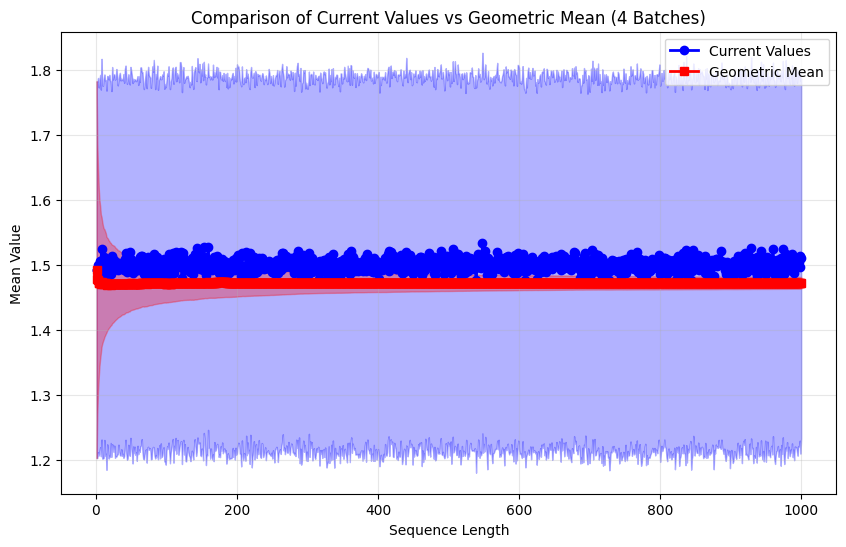

Current Values (final): 1.509 ±  0.277
Geometric Mean (final): 1.472 ±  0.009
0.03749614351015795


In [26]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate 4 batches of sample data points
num_batches = 1000
sequence_length = 1000

# Generate data for each batch
all_current_values = []
all_geometric_means = []

for batch in range(num_batches):
    data_points = [np.random.uniform(1., 2.) for _ in range(sequence_length)]
    
    # Calculate current values and geometric mean for cumulative sequences
    sequence_lengths = range(1, sequence_length + 1)
    current_values = []
    geometric_means = []
    
    for length in sequence_lengths:
        current_data = data_points[:length]
        
        # Current value (the data point at current length)
        current_value = data_points[length-1]
        current_values.append(current_value)
        
        # Geometric mean
        product = 1
        for x in current_data:
            product *= x
        geometric_mean = product ** (1/length)
        geometric_means.append(geometric_mean)
    
    all_current_values.append(current_values)
    all_geometric_means.append(geometric_means)

# Convert to numpy arrays for easier calculation
all_current_values = np.array(all_current_values)
all_geometric_means = np.array(all_geometric_means)

# Calculate mean and standard deviation across batches
current_mean = np.mean(all_current_values, axis=0)
current_std = np.std(all_current_values, axis=0)
geom_mean = np.mean(all_geometric_means, axis=0)
geom_std = np.std(all_geometric_means, axis=0)

sequence_lengths = range(1, sequence_length + 1)

plt.figure(figsize=(10, 6))

# Plot current values with variance band
plt.plot(sequence_lengths, current_mean, marker='o', color='blue', 
         label='Current Values', linewidth=2)
plt.fill_between(sequence_lengths, current_mean - current_std, current_mean + current_std, 
                 color='blue', alpha=0.3)

# Plot geometric mean with variance band
plt.plot(sequence_lengths, geom_mean, marker='s', color='red', 
         label='Geometric Mean', linewidth=2)
plt.fill_between(sequence_lengths, geom_mean - geom_std, geom_mean + geom_std, 
                 color='red', alpha=0.3)
                 
plt.xlabel('Sequence Length')
plt.ylabel('Mean Value')
plt.title('Comparison of Current Values vs Geometric Mean (4 Batches)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("Current Values (final):", round(current_mean[-1], 3), "± ", round(current_std[-1], 3))
print("Geometric Mean (final):", round(geom_mean[-1], 3), "± ", round(geom_std[-1], 3))
print(current_mean[-1] - geom_mean[-1])

动机是，现在的重要性分数仍然来源于重要性采样，其本质是约束优势梯度方向的更新力度。
对于此项
- 目前实则和优势的结构位置平起平坐，更像是动量信息
- 是否可以消融现有的重要性权重项
- 是否可以将 $ \pi_{\theta} / \pi_{\theta_{old}}$ 与 $A$ 都基于学习的方式进行估计
- 设计独特的目标函数和约束项
- LSTM 最后一层的 bias 初始化可以依据不同算法进行初始化，如全部初始化为 A
- 高低频控制，参考 RoPE 和 YaRN 路径

- 消融验证该学习器是否也学习到了 clip 趋势，或软裁剪

如下，本质是 credit assignment 问题，属 Reward Shaping 范畴。

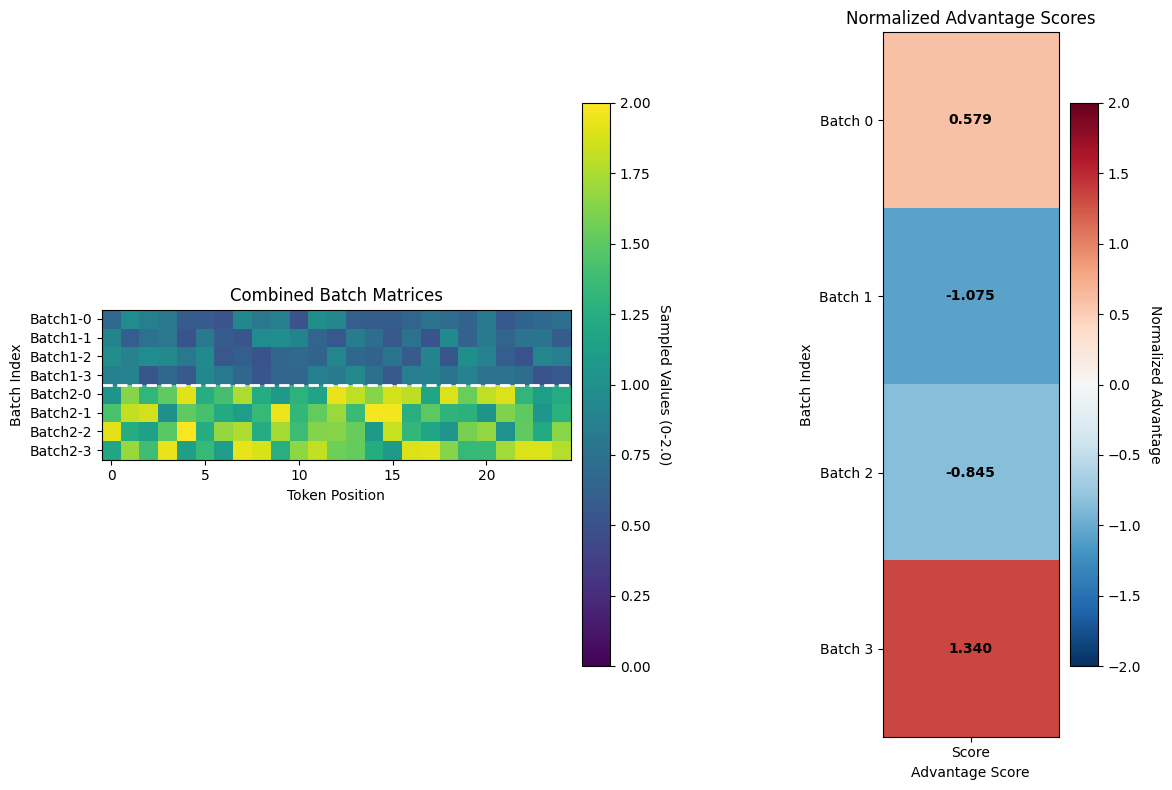

Raw advantages: [ 0.56812658 -1.66344014 -1.35348514  1.59421675]
Mean: -0.214, Std: 1.349
Normalized advantages: [ 0.57946125 -1.07460966 -0.84486634  1.34001476]


In [7]:
# Create visualization of batch matrix and advantage scores
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate first batch matrix with values sampled from 0.5 to 1
batch_matrix_1 = np.random.uniform(0.5, 1.0, (4, 25))

# Generate second batch matrix with values sampled from 1 to 2
batch_matrix_2 = np.random.uniform(1.0, 2.0, (4, 25))

# Combine both batch matrices vertically
combined_batch_matrix = np.vstack([batch_matrix_1, batch_matrix_2])

# Generate 4 random advantage scores
raw_advantages = np.random.uniform(-2, 2, 4)

# Normalize advantage scores using their mean and std
adv_mean = np.mean(raw_advantages)
adv_std = np.std(raw_advantages)
normalized_advantages = (raw_advantages - adv_mean) / (adv_std + 1e-8)  # Add small epsilon to avoid division by zero

# Create figure with two subplots arranged in 1x2 grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Left subplot: Combined batch matrix heatmap with square cells
im1 = ax1.imshow(combined_batch_matrix, cmap='viridis', aspect='equal', vmin=0, vmax=2.0)
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Batch Index')
ax1.set_xticks(range(0, 25, 5))
ax1.set_yticks(range(8))
ax1.set_yticklabels([f'Batch1-{i}' for i in range(4)] + [f'Batch2-{i}' for i in range(4)])
ax1.set_title('Combined Batch Matrices')

# Add horizontal line to separate the two batch matrices
ax1.axhline(y=3.5, color='white', linewidth=2, linestyle='--')

# Add colorbar for batch matrices
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, location='right', pad=0.02)
cbar1.set_label('Sampled Values (0-2.0)', rotation=270, labelpad=15)

# Right subplot: Advantage scores with square cells
advantage_matrix = normalized_advantages.reshape(4, 1)
im2 = ax2.imshow(advantage_matrix, cmap='RdBu_r', aspect='equal', vmin=-2, vmax=2)
ax2.set_xlabel('Advantage Score')
ax2.set_ylabel('Batch Index')
ax2.set_xticks([0])
ax2.set_xticklabels(['Score'])
ax2.set_yticks(range(4))
ax2.set_yticklabels([f'Batch {i}' for i in range(4)])
ax2.set_title('Normalized Advantage Scores')

# Add text annotations for advantage values
for i in range(4):
    ax2.text(0, i, f'{normalized_advantages[i]:.3f}', 
             ha='center', va='center', fontweight='bold', fontsize=10)

# Add colorbar for advantage scores
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, location='right', pad=0.02)
cbar2.set_label('Normalized Advantage', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Raw advantages: {raw_advantages}")
print(f"Mean: {adv_mean:.3f}, Std: {adv_std:.3f}")
print(f"Normalized advantages: {normalized_advantages}")
